In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

# Path to your zip file in Google Drive
zip_path = '/content/archive.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/bank_operations_fraud_analysis')

In [6]:
import numpy as np # linear algebra
import pandas as pd

import os

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import altair as alt
import warnings
warnings.filterwarnings('ignore')
import re
import folium
from folium.plugins import MarkerCluster

In [8]:
df_train = pd.read_csv("/content/archive.zip")

In [9]:
df_train.head(5)


,Transaction ID,Sender Account ID,Receiver Account ID,Transaction Amount,Transaction Type,Timestamp,Transaction Status,Fraud Flag,Geolocation (Latitude/Longitude),Device Used,Network Slice ID,Latency (ms),Slice Bandwidth (Mbps),PIN Code
0,TXN9520068950,ACC14994,ACC16656,495.90,Deposit,2025-01-17 10:14:00,Failed,True,"34.0522 N, -74.006 W",Desktop,Slice3,10,179,3075
1,TXN9412011085,ACC58958,ACC32826,529.62,Withdrawal,2025-01-17 10:51:00,Success,False,"35.6895 N, -118.2437 W",Mobile,Slice2,11,89,2369
2,TXN4407425052,ACC56321,ACC92481,862.47,Withdrawal,2025-01-17 10:50:00,Failed,False,"48.8566 N, 2.3522 W",Mobile,Slice1,4,53,8039
3,TXN2214150284,ACC48650,ACC76457,1129.88,Transfer,2025-01-17 10:56:00,Success,True,"34.0522 N, -74.006 W",Mobile,Slice3,10,127,6374
4,TXN4247571145,ACC60921,ACC11419,933.24,Deposit,2025-01-17 10:25:00,Success,True,"55.7558 N, 37.6173 W",Mobile,Slice3,20,191,8375


In [10]:
print(df_train.isnull().sum())


Transaction ID                      0
Sender Account ID                   0
Receiver Account ID                 0
Transaction Amount                  0
Transaction Type                    0
Timestamp                           0
Transaction Status                  0
Fraud Flag                          0
Geolocation (Latitude/Longitude)    0
Device Used                         0
Network Slice ID                    0
Latency (ms)                        0
Slice Bandwidth (Mbps)              0
PIN Code                            0
dtype: int64


In [11]:
num_entries = df_train.shape[0]
print(f"Size of train data : {num_entries}")

Size of train data : 1000


In [12]:
df_train.dtypes

,0
Transaction ID,object
Sender Account ID,object
Receiver Account ID,object
Transaction Amount,float64
Transaction Type,object
Timestamp,object
Transaction Status,object
Fraud Flag,bool
Geolocation (Latitude/Longitude),object
Device Used,object


In [13]:
for i,col in enumerate(['Transaction Type','Transaction Status','Fraud Flag','Device Used','Network Slice ID']):
    print(col, ':', df_train[col].unique(), '\n')

Transaction Type : ['Deposit' 'Withdrawal' 'Transfer'] 

Transaction Status : ['Failed' 'Success'] 

Fraud Flag : [ True False] 

Device Used : ['Desktop' 'Mobile'] 

Network Slice ID : ['Slice3' 'Slice2' 'Slice1'] 



In [14]:
def parse_coordinates(coord_str):
    """Parses latitude and longitude from a string, handling variations."""
    if not isinstance(coord_str, str):
        return None, None

    coord_str = coord_str.strip()


    coord_str = coord_str.replace(", ", ",")
    coord_str = coord_str.replace(" ,", ",")

    coord_str = re.sub(r"([0-9.])[NS](.*)", r"\1 N \2", coord_str)
    coord_str = re.sub(r"([0-9.])[EW](.*)", r"\1 E \2", coord_str)


    match = re.match(r"([-+]?\d*\.?\d+)\s*[NS]?,\s*([-+]?\d*\.?\d+)\s*[EW]?", coord_str)

    if match:
        try:
            lat = float(match.group(1))
            lon = float(match.group(2))

            if "S" in coord_str.upper():
                lat = -lat
            if "W" in coord_str.upper():
                lon = -lon

            return lat, lon
        except ValueError:
            return None, None
    else:
        return None, None


def create_lat_long_columns(df, coord_column="Geolocation (Latitude/Longitude)"):
    """Creates 'Latitude' and 'Longitude' columns in float format."""

    lats = []
    lons = []

    for _, row in df.iterrows():
        coord_str = row[coord_column]
        lat, lon = parse_coordinates(coord_str)
        lats.append(lat)
        lons.append(lon)

    df['Latitude'] = lats
    df['Longitude'] = lons


    df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

    return df

In [15]:
df_train = create_lat_long_columns(df_train)
df_train.head(5)

,Transaction ID,Sender Account ID,Receiver Account ID,Transaction Amount,Transaction Type,Timestamp,Transaction Status,Fraud Flag,Geolocation (Latitude/Longitude),Device Used,Network Slice ID,Latency (ms),Slice Bandwidth (Mbps),PIN Code,Latitude,Longitude
0,TXN9520068950,ACC14994,ACC16656,495.90,Deposit,2025-01-17 10:14:00,Failed,True,"34.0522 N, -74.006 W",Desktop,Slice3,10,179,3075,34.0522,74.0060
1,TXN9412011085,ACC58958,ACC32826,529.62,Withdrawal,2025-01-17 10:51:00,Success,False,"35.6895 N, -118.2437 W",Mobile,Slice2,11,89,2369,35.6895,118.2437
2,TXN4407425052,ACC56321,ACC92481,862.47,Withdrawal,2025-01-17 10:50:00,Failed,False,"48.8566 N, 2.3522 W",Mobile,Slice1,4,53,8039,48.8566,-2.3522
3,TXN2214150284,ACC48650,ACC76457,1129.88,Transfer,2025-01-17 10:56:00,Success,True,"34.0522 N, -74.006 W",Mobile,Slice3,10,127,6374,34.0522,74.0060
4,TXN4247571145,ACC60921,ACC11419,933.24,Deposit,2025-01-17 10:25:00,Success,True,"55.7558 N, 37.6173 W",Mobile,Slice3,20,191,8375,55.7558,-37.6173


In [16]:
df_fraud = df_train[df_train['Fraud Flag'] == True]


if df_fraud.empty:
    print("No fraudulent transactions found.")
else:

    map_center = [df_fraud["Latitude"].mean(), df_fraud["Longitude"].mean()]


    print_map = folium.Map(location=map_center, zoom_start=2, min_zoom=2, max_zoom=18)


    min_lat = df_fraud['Latitude'].min()
    max_lat = df_fraud['Latitude'].max()
    min_lon = df_fraud['Longitude'].min()
    max_lon = df_fraud['Longitude'].max()
    print_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])


    marker_cluster = MarkerCluster().add_to(print_map)


    for _, row in df_fraud.iterrows():
        popup_text = f"Latitude: {row['Latitude']}, Longitude: {row['Longitude']}"
        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            icon=folium.Icon(color="blue"),
            popup=popup_text
        ).add_to(marker_cluster)


    map_path = "fraudulent_transactions_map.html"
    print_map.save(map_path)
    print(f"Map saved to {map_path}")


    from IPython.display import IFrame
    IFrame(map_path, width=900, height=600)


print_map

Map saved to fraudulent_transactions_map.html


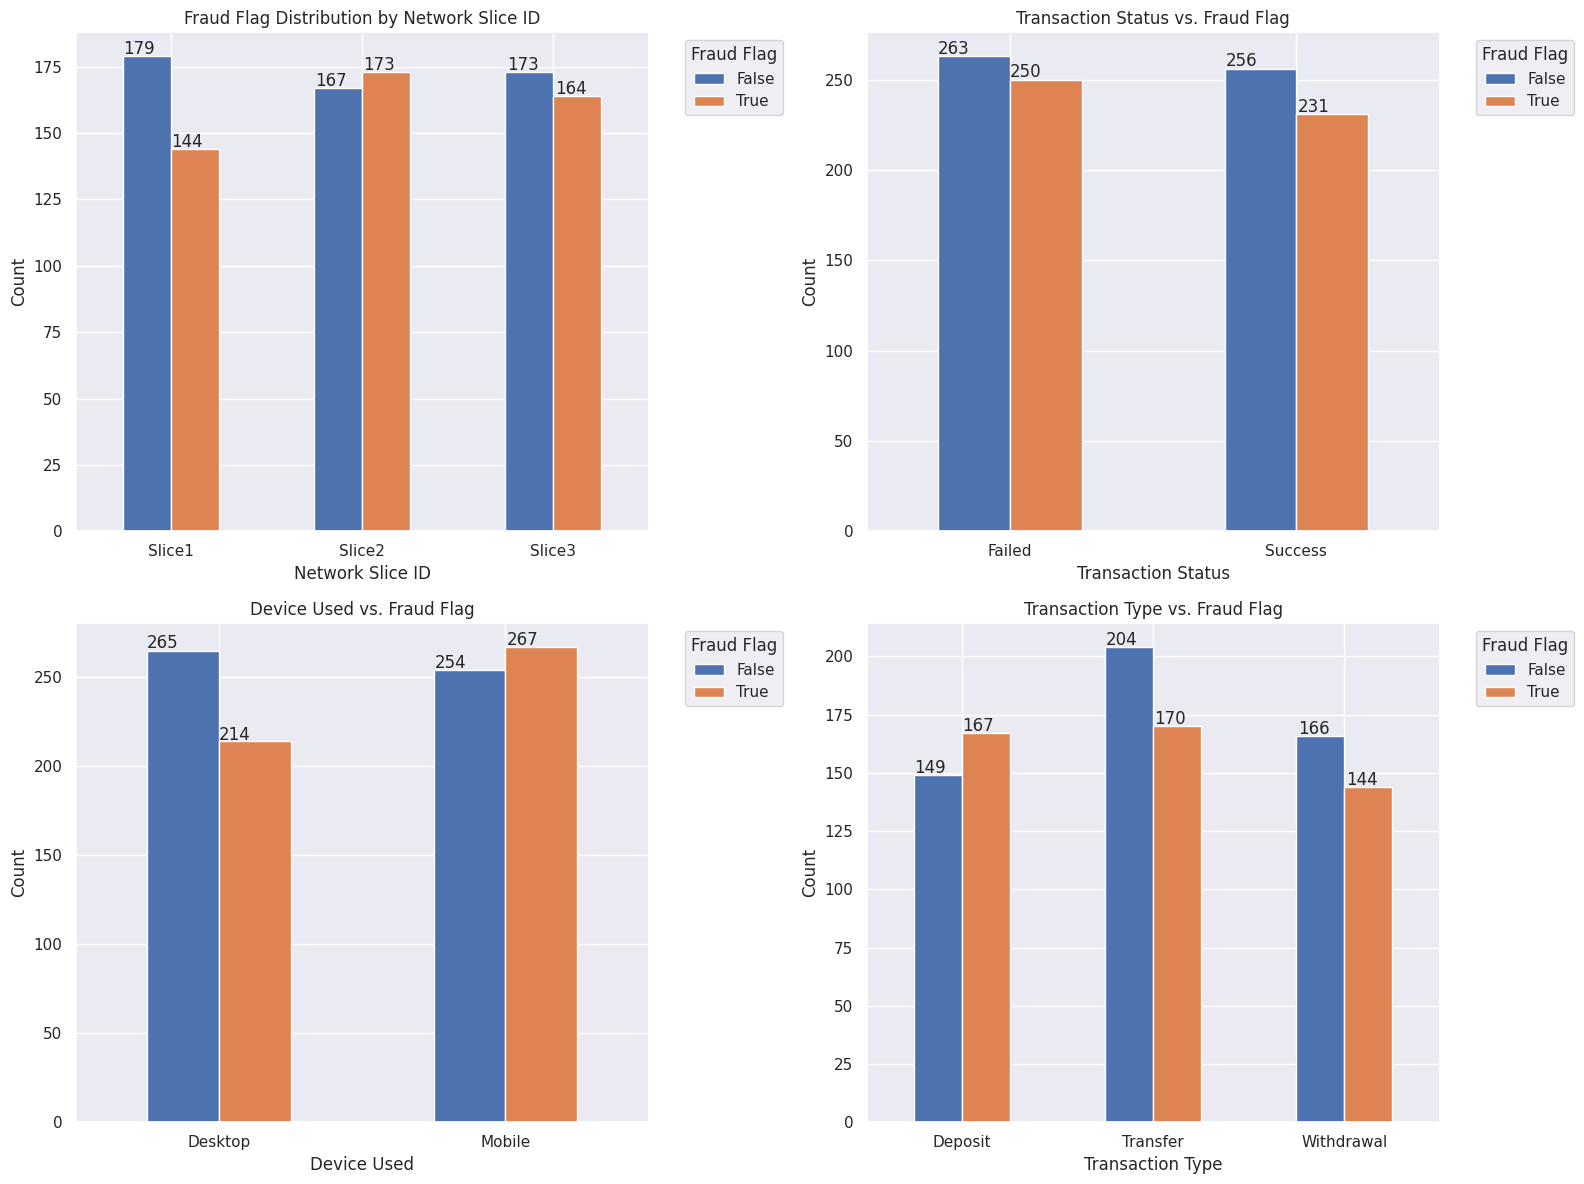

In [17]:
grouped_network = df_train.groupby(['Network Slice ID', 'Fraud Flag']).size().unstack(fill_value=0)


status_counts = df_train.groupby(['Transaction Status', 'Fraud Flag']).size().unstack(fill_value=0)


device_counts = df_train.groupby(['Device Used', 'Fraud Flag']).size().unstack(fill_value=0)


type_counts = df_train.groupby(['Transaction Type', 'Fraud Flag']).size().unstack(fill_value=0)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))


ax1 = grouped_network.plot(kind='bar', rot=0, ax=axes[0, 0])
axes[0, 0].set_title('Fraud Flag Distribution by Network Slice ID')
axes[0, 0].set_xlabel('Network Slice ID')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Fraud Flag', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


ax2 = status_counts.plot(kind='bar', rot=0, ax=axes[0, 1])
axes[0, 1].set_title('Transaction Status vs. Fraud Flag')
axes[0, 1].set_xlabel('Transaction Status')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Fraud Flag', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


ax3 = device_counts.plot(kind='bar', rot=0, ax=axes[1, 0])
axes[1, 0].set_title('Device Used vs. Fraud Flag')
axes[1, 0].set_xlabel('Device Used')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Fraud Flag', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax3.patches:
    ax3.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


ax4 = type_counts.plot(kind='bar', rot=0, ax=axes[1, 1])
axes[1, 1].set_title('Transaction Type vs. Fraud Flag')
axes[1, 1].set_xlabel('Transaction Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Fraud Flag', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax4.patches:
    ax4.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


plt.tight_layout()
plt.show()